In [1]:
from qutip import mesolve, basis, jmat
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator, floquet_modes
import time as time
import matplotlib.pyplot as plt

def floquet_modes_phtr(H, T, args=None, parallel=False, sort=False, U=None):
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, options=options)

    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

def drive_exact(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.cos(w*t) + h0

def get_hamiltonians_exact(args):
    N = args['N']
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      # kacNorm
    H0 = kn * sz **2
    H1 = 2 * sx
    return H0,H1

def floq_evolv_exact(args):
    w = args['omega']
    T = 2 * np.pi/w
    H0, H1 = get_hamiltonians_exact(args)
    H = [H0,[H1,drive_exact]]
    try:
        f_modes_0, f_energies = floquet_modes_phtr(H, T, args=args)
        return f_modes_0, f_energies, w
    except:
        return None

print('definition done!')

definition done!


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.special import jn_zeros, j0
import math
from qutip import Options
from itertools import compress

#from tqdm import tqdm
import h5py, time
freezing_pts = jn_zeros(0, 3)
start = time.time()

#Ns = [10,20,30,50, 100,150]
#ostp = [1e4,1e5,1e6,1e7,1e11, 1e14]

Ns = [800]
ostp = [1e11]
nprocs = 48
# which number of floquet mode we take
nth = 0       
h0 = np.sqrt(3)/2**4
ws = np.exp(np.linspace(np.log(901), np.log(1100), 10))

#ws1 = np.exp(np.linspace(np.log(1.0), np.log(5), 10))
#ws2 = np.exp(np.linspace(np.log(6,), np.log(15), 30))
#ws3 = np.exp(np.linspace(np.log(17.), np.log(100.0), 10))
#ws = np.concatenate((ws1, ws3 , ws4))

if __name__ == '__main__':    
    for nn,N in enumerate(Ns):
        start1 = time.time()
        opts = Options(nsteps = ostp[nn])
        params = [{'h0':h0, 'h': 1/4 * w * freezing_pts[0], 'omega':w, 'N':N, 'opts':opts} for w in ws]
        
        with Pool(processes = nprocs) as p:
            data = p.map(floq_evolv_exact,params)

        evec_f = [np.array(data[j][0])[:,:,0] if data[j] is not None else None for j in range(len(ws))]
        boolfilt = [np.prod(a != None, dtype=bool) for a in evec_f]
        evec_f = np.array(list(compress(evec_f, boolfilt)))
        
        phs_f = [np.array(data[i][1]) if data[i] is not None else None for i in range(len(ws))]
        boolfilt = [np.prod(a != None, dtype=bool) for a in phs_f]
        phs_f = np.array(list(compress(phs_f, boolfilt)))
        
        ws = [data[i][2] if data[i] is not None else None for i in range(len(ws))]
        boolfilt = [np.prod(a != None, dtype=bool) for a in ws]
        ws = np.array(list(compress(ws, boolfilt)))

        evals_single_path = np.zeros(len(ws))
        iprmat_single_path = np.zeros(len(ws))
        iprmat = np.zeros((len(ws),2*N+1))

        sx = jmat(N,"x")
        en, st = sx.eigenstates()

        for xx,w in enumerate(ws):
            #Get the previous Floquet Eigensystem
            if xx == 0:
                evals_prev = phs_f[xx].real
                evecs_prev = evec_f[xx]
            else:
                evals_prev = phs_f[xx-1].real
                evecs_prev = evec_f[xx-1]

            #Sort the Floquet states of this itertaion accordingly to orthonormality with the previous ones
            evals_curr = phs_f[xx]
            evecs_curr = evec_f[xx]
            t = np.copy(evecs_curr)
            condition = np.abs(np.around(evecs_prev.T.conj() @ evecs_curr, 1))
            evals_curr = evals_curr[np.argmax(condition, axis=1)]        
            evecs_curr = evecs_curr[:,np.argmax(condition, axis=1)]

            evals_single_path[xx] = evals_curr[nth]
            f_states = evec_f[xx]
            iprmat[xx,:] = [np.sum([np.abs(Qobj(state).overlap(sx_ev))**4 for sx_ev in st],\
                                   axis=-1) for state in f_states]

            iprmat_single_path[xx] = iprmat[xx,:][nth]

        # save the data
        filename = 'phase_crossover_N' + str(N) +'_.hdf5'

        with h5py.File(filename, 'w') as hf:
            hf.create_dataset('ws', np.shape(ws), data=ws)
            hf.create_dataset('evals_single_path', np.shape(evals_single_path), data=evals_single_path)
            hf.create_dataset('iprmat_single_path', np.shape(iprmat_single_path), data=iprmat_single_path)
            hf.attrs['N'] = N
            hf.attrs['nth'] = nth

        print("For N = ", N, "with", nprocs, "processors : time taken ", (time.time()-start1)/60, ' minutes !')
    print('\n run complete!! \n\n TOTAL TIME TAKEN :', (time.time()-start)/60, ' minutes !')

For N =  10 with 16 processors : time taken  0.019106642405192057  minutes !
For N =  24 with 16 processors : time taken  0.09804427226384481  minutes !

 run complete!! 

 TOTAL TIME TAKEN : 0.1171732227007548  minutes !


In [44]:
import h5py
filename1="phaserun/N_120_old.hdf5"
filename2="phaserun/phase_crossover_N120_.hdf5"

with h5py.File(filename1, 'r') as f:    
    ws_1 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_1 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data1 = np.vstack((ws_1,iprmat_single_path_1)).T
    
with h5py.File(filename2, 'r') as f:    
    ws_2 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_2 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data2 = np.vstack((ws_2,iprmat_single_path_2)).T

N_120_data = np.concatenate((data1, data2))

In [39]:
import h5py
filename1="phaserun/N_240_old.hdf5"
filename2="phaserun/phase_crossover_N240_.hdf5"

with h5py.File(filename1, 'r') as f:    
    ws_1 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_1 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data1 = np.vstack((ws_1,iprmat_single_path_1)).T
    
with h5py.File(filename2, 'r') as f:    
    ws_2 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_2 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data2 = np.vstack((ws_2,iprmat_single_path_2)).T

N_240_data = np.concatenate((data1, data2))

In [40]:
import h5py
filename1="phaserun/N_480_old.hdf5"
filename2="phaserun/phase_crossover_N480_.hdf5"

with h5py.File(filename1, 'r') as f:    
    ws_1 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_1 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data1 = np.vstack((ws_1,iprmat_single_path_1)).T
    
with h5py.File(filename2, 'r') as f:    
    ws_2 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_2 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data2 = np.vstack((ws_2,iprmat_single_path_2)).T

N_480_data = np.concatenate((data1, data2))

In [41]:
import h5py
filename1="phaserun/N_800_old.hdf5"
filename2="phaserun/phase_crossover_N800_.hdf5"

with h5py.File(filename1, 'r') as f:    
    ws_1 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_1 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data1 = np.vstack((ws_1,iprmat_single_path_1)).T
    
with h5py.File(filename2, 'r') as f:    
    ws_2 = f['ws'][()]
    evals_single_path = f['evals_single_path'][()]
    iprmat_single_path_2 = f['iprmat_single_path'][()]
    N = f.attrs['N']
    data2 = np.vstack((ws_2,iprmat_single_path_2)).T

N_800_data = np.concatenate((data1, data2))

In [10]:
!ls phaserun/*.hdf5 > file_phasetran.txt
!cat file_phasetran.txt
!date

phaserun/N_120_old.hdf5
phaserun/N_240_old.hdf5
phaserun/N_480_old.hdf5
phaserun/N_800_old.hdf5
phaserun/phase_crossover_N10_.hdf5
phaserun/phase_crossover_N120_.hdf5
phaserun/phase_crossover_N240_.hdf5
phaserun/phase_crossover_N30_.hdf5
phaserun/phase_crossover_N480_.hdf5
phaserun/phase_crossover_N60_.hdf5
phaserun/phase_crossover_N800_.hdf5
phaserun/phase_crossover_N960_.hdf5
Wednesday 06 December 2023 12:45:15 PM IST


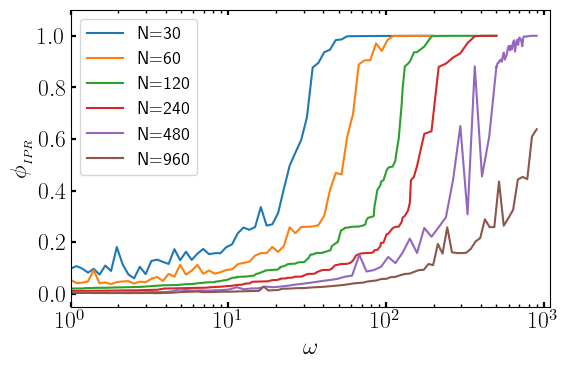

CPU times: user 959 ms, sys: 313 ms, total: 1.27 s
Wall time: 3.38 s


In [55]:
%%time
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({ "figure.figsize": (6, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 17, "font.sans-serif": ["Computer Modern"]})

Nvals = [30, 60]

for N in Nvals:
    filename = f"phaserun/phase_crossover_N{N}_.hdf5" 

    with h5py.File(filename, 'r') as f:    
        ws = f['ws'][()]
        evals_single_path = f['evals_single_path'][()]
        iprmat_single_path = f['iprmat_single_path'][()]
        N = f.attrs['N']
        lbl = 'N=' + str(N)
        plt.plot(ws, iprmat_single_path, label = lbl)


#plt.plot(N_800_data[:,0],N_800_data[:,1], label="N=800")
plt.plot(np.sort(N_120_data[:,0]),np.sort(N_120_data[:,1]), label="N=120")
plt.plot(np.sort(N_240_data[:,0]),np.sort(N_240_data[:,1]), label="N=240")
plt.plot(N_480_data[:,0],N_480_data[:,1], label="N=480")

Nvals= [960]
for N in Nvals:
    filename = f"phaserun/phase_crossover_N{N}_.hdf5" 

    with h5py.File(filename, 'r') as f:    
        ws = f['ws'][()]
        evals_single_path = f['evals_single_path'][()]
        iprmat_single_path = f['iprmat_single_path'][()]
        N = f.attrs['N']
        lbl = 'N=' + str(N)
        plt.plot(ws, iprmat_single_path, label = lbl)


plt.ylabel(r"$\phi_{{_{{IPR}}}}$")
plt.xlabel(r"$\omega$")
plt.ylim(-0.05,1.1)
plt.xlim(1,1100)
plt.xscale('log')

figname= "phase_dynam1.jpeg" 

plt.tick_params(which='both',axis="x", direction="in")
plt.tick_params(axis="y", direction="in")
plt.tight_layout()
plt.legend(frameon = True, loc = 2,fontsize= 13)
#plt.savefig(figname,dpi=600)
plt.show()